In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os
import scipy.sparse as sp
from scipy.sparse import csr_matrix, save_npz, load_npz
import gzip
import shutil

In [189]:
data = pd.read_csv('Vehicle.csv', index_col=False) 

In [190]:
# -----------------------------
# Step 1: Preprocess Your Data
# -----------------------------

# Load data
data = pd.read_csv('Vehicle.csv', index_col=False)

# Filter the relevant columns
columns_to_keep = ['frame', 'id', 'x', 'y', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration']
data = data[columns_to_keep]

# Filter data for ids from 1 to 101
data = data[data['id'].isin(range(1, 1001))]

# Sort the data by 'id' and 'frame' to ensure correct ordering
data = data.sort_values(by=['id', 'frame'])

# Define the variables to transform
variables = ['x', 'y', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration']

# Determine the sorted frame numbers
frame_numbers = sorted(data['frame'].unique())
max_frames = len(frame_numbers)

# Initialize a list to hold the pivoted dataframes
pivoted_dfs = []

for var in variables:
    # Pivot the data
    pivot_df = data.pivot(index='id', columns='frame', values=var)
    
    # Ensure all frame numbers are represented
    pivot_df = pivot_df.reindex(columns=frame_numbers)
    
    # Rename the columns to include variable name and frame number
    pivot_df.columns = [f'{var}_f{int(col)}' for col in pivot_df.columns]
    
    # Append to the list
    pivoted_dfs.append(pivot_df)

# Start with the first dataframe
merged_df = pivoted_dfs[0]

# Join all pivoted dataframes
for df in pivoted_dfs[1:]:
    merged_df = merged_df.join(df, how='outer')

# Reset index to turn 'id' back into a column
merged_df = merged_df.reset_index()

# Extract the 'id' column
ids = merged_df['id'].values
merged_df = merged_df.drop(columns=['id'])

# Convert the DataFrame to a NumPy array for efficient processing
X_true = merged_df.values  # Shape: (20, 3318)

# Impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean')
X_true_imputed = imputer.fit_transform(X_true)

scaler = StandardScaler()
X_true_standardized = scaler.fit_transform(X_true_imputed)

In [191]:
# Save the transformed data as a CSV at the end of preprocessing
transformed_csv_path = "transformed_vehicle_data.csv"
merged_df_with_id = merged_df.copy()
merged_df_with_id.to_csv(transformed_csv_path, index=False)
print(f"Transformed data saved to '{transformed_csv_path}'.")

# ENCODING

In [ ]:
# --------------------------------------------------
# Step 2: Implement Importance Sampling (Encoding)
# --------------------------------------------------

# Number of IDs and features
N, M = X_true_standardized.shape

# Step 1: Calculate importance scores for each feature (column)
def calculate_feature_importance(X_true):
    """
    Calculate the range (max - min) for each feature.
    Higher range indicates higher variability and importance.
    """
    max_vals = np.max(X_true, axis=0)
    min_vals = np.min(X_true, axis=0)
    range_vals = max_vals - min_vals
    
    # Replace NaN ranges with 0 
    range_vals = np.nan_to_num(range_vals, nan=0.0)
    return range_vals

importance_scores = calculate_feature_importance(X_true_standardized)  #

# Assign importance per entry by replicating importance scores across all IDs
importance_matrix = np.tile(importance_scores, (N, 1))  

# Normalize importance scores to create a probability distribution
total_importance = np.sum(importance_matrix)
prob_matrix = importance_matrix / total_importance  # Each entry represents p(i,j)

# Define the desired sparsity level (e.g., retain 10% of the data)
retain_fraction = 0.00005  # 10% of the total entries

# Calculate the scaled probabilities to achieve the retain_fraction
scaled_prob_matrix = prob_matrix * (retain_fraction * M * N / np.sum(prob_matrix))

# Cap probabilities at 1 to prevent invalid probabilities
scaled_prob_matrix = np.minimum(scaled_prob_matrix, 1.0)

# Set a random seed for reproducibility
np.random.seed(42)

# Generate random values for each entry
random_values = np.random.rand(N, M)

# Create Omega where entries are retained if random_value < scaled_prob
Omega = (random_values < scaled_prob_matrix).astype(int)  # Shape: (200, 3318)

# Create the observed ratings matrix R
R = np.where(Omega == 1, X_true_standardized, 0)  # Shape: (200, 3318)

# Convert Omega and R to sparse matrices for efficient storage
Omega_sparse = csr_matrix(Omega)
R_sparse = csr_matrix(R)

# Save Omega and R as compressed sparse matrices using scipy's save_npz
encoded_folder = "encoded_data"
os.makedirs(encoded_folder, exist_ok=True)  # Create folder if it doesn't exist

Omega_path = os.path.join(encoded_folder, 'Omega_sparse.npz')
R_path = os.path.join(encoded_folder, 'R_sparse.npz')

save_npz(Omega_path, Omega_sparse)
save_npz(R_path, R_sparse)

print("Encoding completed.")
print(f"Desired retain fraction: {retain_fraction}")
print(f"Actual retain fraction after scaling: {Omega_sparse.nnz / (N * M):.4f}")
print(f"Omega shape: {Omega_sparse.shape}")
print(f"R_sparse shape: {R_sparse.shape}")
print(f"Number of observed entries: {Omega_sparse.nnz}")

Encoding completed.
Desired retain fraction: 5e-05
Actual retain fraction after scaling: 0.0001
Omega shape: (100, 13272)
R_sparse shape: (100, 13272)
Number of observed entries: 74


# DECODING

Iteration 0: Error = 89.0718, Rank = 10.0
Iteration 1: Error = 68.8943, Rank = 10
Iteration 2: Error = 68.0827, Rank = 10
Iteration 3: Error = 67.7209, Rank = 10
Iteration 4: Error = 67.5239, Rank = 10
Iteration 5: Error = 67.4058, Rank = 10
Iteration 6: Error = 67.3310, Rank = 10
Iteration 7: Error = 67.2819, Rank = 10
Iteration 8: Error = 67.2490, Rank = 10
Iteration 9: Error = 67.2266, Rank = 10
Iteration 10: Error = 67.2112, Rank = 10
Iteration 11: Error = 67.2006, Rank = 10
Iteration 12: Error = 67.1933, Rank = 10
Iteration 13: Error = 67.1882, Rank = 10
Iteration 14: Error = 67.1847, Rank = 10
Iteration 15: Error = 67.1823, Rank = 10
Iteration 16: Error = 67.1806, Rank = 10
Iteration 17: Error = 67.1795, Rank = 10
Iteration 18: Error = 67.1787, Rank = 10
Iteration 19: Error = 67.1783, Rank = 10
Iteration 20: Error = 67.1779, Rank = 10


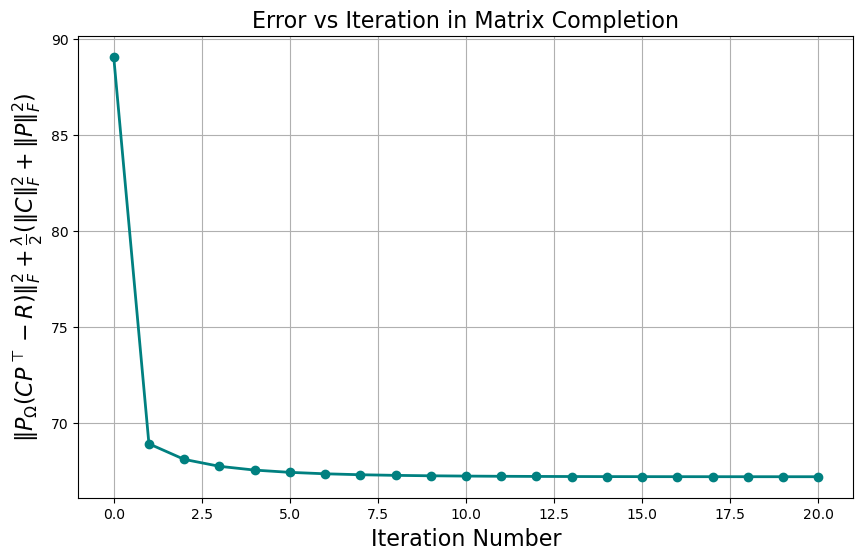

Mean Squared Error on Observed Entries: 0.0005
Mean Squared Error on All Entries: 0.9840


In [ ]:
# -----------------------------
# Step 3: Matrix Completion (Decoding)
# -----------------------------

# Parameters for matrix completion
r = 10              # Number of hidden features
K = 20              # Maximum number of iterations
lambda_reg = 0.1    # Increased regularization weight for stability

# Initialize matrices with small random values for numerical stability
np.random.seed(42)  # For reproducibility
C = np.random.randn(N, r) * 0.1  # Adjusted scale
P = np.random.randn(M, r) * 0.1

errors = np.zeros(K + 1)
ranks = np.zeros(K + 1)

# Regularization term for identity matrix
Ir = np.eye(r)
lam_Ir = lambda_reg * Ir

# Define the error function
def error_func(C, P, R, Omega, lambda_reg):
    reg_term = 0.5 * lambda_reg * (np.linalg.norm(C, 'fro')**2 + np.linalg.norm(P, 'fro')**2)
    reconstruction_error = np.linalg.norm((C @ P.T - R) * Omega, 'fro')**2
    return reg_term + reconstruction_error

# Calculate initial error and rank
errors[0] = error_func(C, P, R, Omega, lambda_reg)
reconstructed = C @ P.T
ranks[0] = np.linalg.matrix_rank(reconstructed)
print(f"Iteration 0: Error = {errors[0]:.4f}, Rank = {ranks[0]}")

# Block Coordinate Descent for matrix completion
for k in range(K):
    # Update user features (C)
    for n in range(N):
        inx = np.where(Omega[n, :] == 1)[0]  # Indices of observed entries for user n
        if len(inx) > 0:
            S1 = np.zeros((r, r))
            S2 = np.zeros((r, 1))
            for i in inx:
                S1 += np.outer(P[i, :], P[i, :])  # P[i].T @ P[i]
                S2 += R[n, i] * P[i, :].reshape(-1, 1)  # R[n, i] * P[i]'
            # Solve (S1 + lambda*I) C[n,:].T = S2
            try:
                C[n, :] = np.linalg.solve(S1 + lam_Ir, S2).flatten()
            except np.linalg.LinAlgError:
                print(f"LinAlgError encountered while updating C for user {n} at iteration {k + 1}. Setting C[{n}, :] to zeros.")
                C[n, :] = np.zeros(r)

    # Update product features (P)
    for m in range(M):
        inx = np.where(Omega[:, m] == 1)[0]  # Indices of observed entries for product m
        if len(inx) > 0:
            T1 = np.zeros((r, r))
            T2 = np.zeros((r, 1))
            for i in inx:
                T1 += np.outer(C[i, :], C[i, :])  # C[i].T @ C[i]
                T2 += R[i, m] * C[i, :].reshape(-1, 1)  # R[i, m] * C[i]'
            # Solve (T1 + lambda*I) P[m,:].T = T2
            try:
                P[m, :] = np.linalg.solve(T1 + lam_Ir, T2).flatten()
            except np.linalg.LinAlgError:
                print(f"LinAlgError encountered while updating P for product {m} at iteration {k + 1}. Setting P[{m}, :] to zeros.")
                P[m, :] = np.zeros(r)

    # Compute error and rank
    reconstructed = C @ P.T
    if np.isnan(reconstructed).any() or np.isinf(reconstructed).any():
        print(f"NaN or Inf detected in reconstructed matrix at iteration {k + 1}. Stopping iterations.")
        break

    current_error = error_func(C, P, R, Omega, lambda_reg)
    current_rank = np.linalg.matrix_rank(reconstructed)
    errors[k + 1] = current_error
    ranks[k + 1] = current_rank

    print(f"Iteration {k + 1}: Error = {current_error:.4f}, Rank = {current_rank}")

# Plot errors
plt.figure(figsize=(10, 6))
plt.plot(errors, color='teal', linewidth=2, marker='o')
plt.xlabel('Iteration Number', fontsize=16)
plt.ylabel(r'$\|P_{\Omega}(CP^\top - R)\|_F^2 + \frac{\lambda}{2}(\|C\|_F^2 + \|P\|_F^2)$', fontsize=16)
plt.title("Error vs Iteration in Matrix Completion", fontsize=16)
plt.grid(True)
plt.show()

# Evaluate reconstruction accuracy
# Calculate MSE only on observed entries
observed_indices = Omega == 1
mse_observed = mean_squared_error(R[observed_indices], reconstructed[observed_indices])
print(f"Mean Squared Error on Observed Entries: {mse_observed:.4f}")

# Calculate MSE on all entries (if X_true is known)
mse_all = mean_squared_error(X_true_standardized, reconstructed)
print(f"Mean Squared Error on All Entries: {mse_all:.4f}")

In [ ]:
# -----------------------------
# Step 4: Save Reconstructed Matrix to CSV
# -----------------------------

# Inverse Transform the Reconstructed Data
reconstructed_original = scaler.inverse_transform(reconstructed)

# Combine Reconstructed Data with Original Data
# (Issue) Create a mask of original missing entries (True where data was missing)
original_missing_mask = np.isnan(X_true)

# Initialize final_matrix with original data (includes NaNs)
final_matrix = X_true.copy()

# Replace only the missing entries with reconstructed values
final_matrix[original_missing_mask] = reconstructed_original[original_missing_mask]

df_reconstructed = pd.DataFrame(final_matrix, columns=merged_df.columns)
df_reconstructed.insert(0, 'id', ids)
df_reconstructed.to_csv("reconstructed_data.csv", index=False)

print("Reconstructed matrix saved to 'reconstructed_data.csv'.")

Reconstructed matrix saved to 'reconstructed_data.csv'.


In [ ]:
# -----------------------------------------------
# Step 5: Compare the Efficiency of Compression
# -----------------------------------------------

# Define file paths
csv_file = transformed_csv_path
compressed_npz_file = os.path.join(encoded_folder, 'Omega_sparse.npz')

# Considering the size of both Omega and R for encoded_size
encoded_size = os.path.getsize(Omega_path) + os.path.getsize(R_path)

# Calculate compression ratio
original_size = os.path.getsize(csv_file)
compression_ratio = original_size / encoded_size

print("\nCompression Efficiency:")
print(f"Original size: {original_size} bytes")
print(f"Encoded size (Omega + R): {encoded_size} bytes")
print(f"Compression ratio (Original / Encoded): {compression_ratio:.2f}")



Compression Efficiency:
Original size: 2374045 bytes
Encoded size (Omega + R): 3031 bytes
Compression ratio (Original / Encoded): 783.25
